In [339]:
%install_ext http://raw.github.com/jrjohansson/version_information/master/version_information.py
%load_ext version_information
%reload_ext version_information
%version_information numpy, scipy, matplotlib, pandas

Installed version_information.py. To use it, type:
  %load_ext version_information
The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information


Software versions
Python 2.7.10 64bit [GCC 4.2.1 (Apple Inc. build 5666) (dot 3)]
IPython 4.0.0
OS Darwin 14.5.0 x86_64 i386 64bit
numpy 1.9.2
scipy 0.16.0
matplotlib 1.4.3
pandas 0.16.2
Fri Sep 18 00:47:25 2015 PDT

In [340]:
!pwd

/Users/berkeleyalmand/repos/ski_in_solitude


[autoreload of version_information failed: Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ImportError: No module named version_information
]


In [198]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
import datetime
import seaborn as sns
from pandas.tseries.holiday import USFederalHolidayCalendar


%load_ext autoreload
%autoreload 2
from functions import *
from plots import *

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 8  # plotsize 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Import traffic data

In [199]:
df_traf = pd.DataFrame.from_csv('data/berthoud_skiers.csv')

In [200]:
df_traf.head()

,away_WP,to_WP,day_of_week,skiers
FormattedDate,,,,
2014-11-14,0,1632,4,1632
2014-11-15,1695,1964,5,1901
2014-11-16,3390,1489,6,0
2014-11-17,1716,1493,0,-223
2014-11-18,1544,1531,1,-236


# Import weather data

In [201]:
df_met = pd.DataFrame.from_csv('data/all_weather_clean.csv')

In [202]:
resamp_time = '1440Min'
df_met = df_met.resample(resamp_time)

In [203]:
df_met.head()

,Time,freezing_fog,heavy_snow,light_snow,mist,thunderstorm_haze,thunderstorm_snow,clear_sky,broken_sky,scattered_sky,overcast,snowfall,high_temp_C,low_temp_C,max_windspeed,mean_windspeed,max_rh,mean_rh,mean_visibility
Date,,,,,,,,,,,,,,,,,,,
2014-11-01,1179.805556,0.000000,0.000000,0.000000,0.000000,0.027778,0.000000,0.847222,0.013889,0.138889,0.000000,0.00,5,-1,37,18.270270,96,88.430556,10.000000
2014-11-02,1211.217391,0.043478,0.014493,0.028986,0.072464,0.028986,0.000000,0.507246,0.086957,0.289855,0.115942,0.06,-1,-6,36,15.444444,96,86.623188,8.623188
2014-11-03,1243.306452,0.370968,0.048387,0.096774,0.080645,0.000000,0.032258,0.096774,0.096774,0.080645,0.725806,0.14,-6,-11,33,16.163265,92,85.919355,2.281250
2014-11-04,1179.819444,0.000000,0.000000,0.000000,0.013889,0.000000,0.000000,0.597222,0.000000,0.000000,0.291667,0.45,-5,-13,44,19.014286,96,83.986111,9.425000
2014-11-05,1179.875000,0.055556,0.000000,0.013889,0.055556,0.000000,0.000000,0.694444,0.041667,0.055556,0.208333,0.00,-1,-10,43,19.628571,92,84.708333,9.013889


## Combine the traffic and met data.

In [204]:
df_all = df_traf.join(df_met,how='outer')

#### Drop to and from traffic data

In [205]:
df_all.drop(['to_WP', 'away_WP', 'Time'], axis=1, inplace=True)

In [206]:
df_all.head()

,day_of_week,skiers,freezing_fog,heavy_snow,light_snow,mist,thunderstorm_haze,thunderstorm_snow,clear_sky,broken_sky,scattered_sky,overcast,snowfall,high_temp_C,low_temp_C,max_windspeed,mean_windspeed,max_rh,mean_rh,mean_visibility
2014-11-01,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.027778,0.000000,0.847222,0.013889,0.138889,0.000000,0.00,5,-1,37,18.270270,96,88.430556,10.000000
2014-11-02,NaN,NaN,0.043478,0.014493,0.028986,0.072464,0.028986,0.000000,0.507246,0.086957,0.289855,0.115942,0.06,-1,-6,36,15.444444,96,86.623188,8.623188
2014-11-03,NaN,NaN,0.370968,0.048387,0.096774,0.080645,0.000000,0.032258,0.096774,0.096774,0.080645,0.725806,0.14,-6,-11,33,16.163265,92,85.919355,2.281250
2014-11-04,NaN,NaN,0.000000,0.000000,0.000000,0.013889,0.000000,0.000000,0.597222,0.000000,0.000000,0.291667,0.45,-5,-13,44,19.014286,96,83.986111,9.425000
2014-11-05,NaN,NaN,0.055556,0.000000,0.013889,0.055556,0.000000,0.000000,0.694444,0.041667,0.055556,0.208333,0.00,-1,-10,43,19.628571,92,84.708333,9.013889


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1169260d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x118826c10>]], dtype=object)

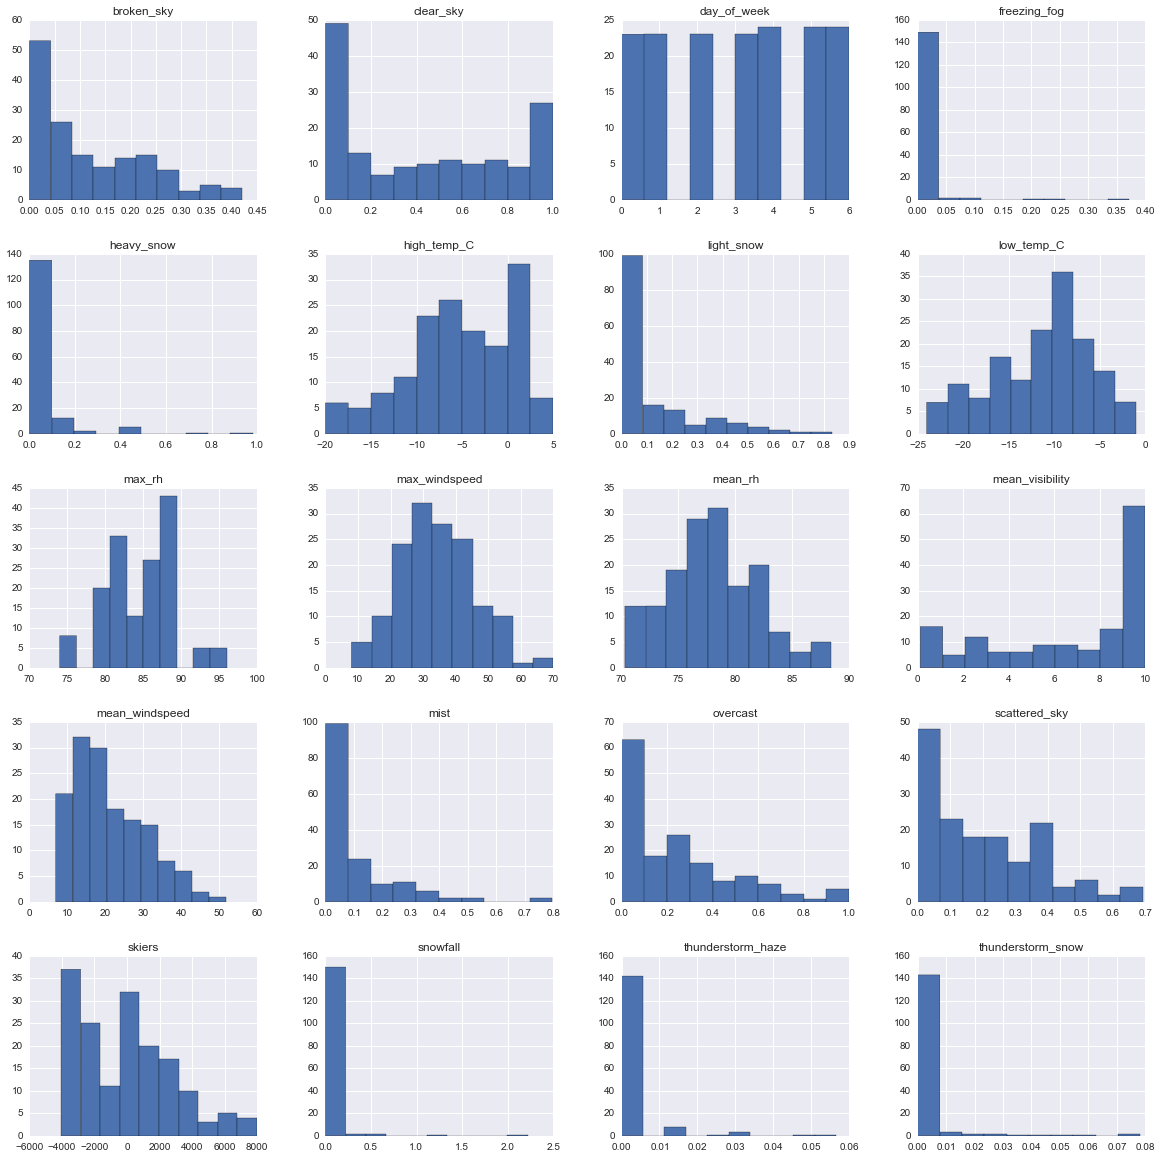

In [207]:
df_all.hist(figsize=(20,20), xlabelsize = 10, ylabelsize = 10)

#### Create a crowd yesterday column

In [208]:
df_all['crowd_yest'] = df_all.skiers.shift(1)

In [209]:
df_all.head()

,day_of_week,skiers,freezing_fog,heavy_snow,light_snow,mist,thunderstorm_haze,thunderstorm_snow,clear_sky,broken_sky,...,overcast,snowfall,high_temp_C,low_temp_C,max_windspeed,mean_windspeed,max_rh,mean_rh,mean_visibility,crowd_yest
2014-11-01,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.027778,0.000000,0.847222,0.013889,...,0.000000,0.00,5,-1,37,18.270270,96,88.430556,10.000000,NaN
2014-11-02,NaN,NaN,0.043478,0.014493,0.028986,0.072464,0.028986,0.000000,0.507246,0.086957,...,0.115942,0.06,-1,-6,36,15.444444,96,86.623188,8.623188,NaN
2014-11-03,NaN,NaN,0.370968,0.048387,0.096774,0.080645,0.000000,0.032258,0.096774,0.096774,...,0.725806,0.14,-6,-11,33,16.163265,92,85.919355,2.281250,NaN
2014-11-04,NaN,NaN,0.000000,0.000000,0.000000,0.013889,0.000000,0.000000,0.597222,0.000000,...,0.291667,0.45,-5,-13,44,19.014286,96,83.986111,9.425000,NaN
2014-11-05,NaN,NaN,0.055556,0.000000,0.013889,0.055556,0.000000,0.000000,0.694444,0.041667,...,0.208333,0.00,-1,-10,43,19.628571,92,84.708333,9.013889,NaN


#### Create dummy variables for days of the week.

In [210]:
df_all = pd.concat([pd.get_dummies(df_all.day_of_week, prefix='day'),df_all], axis=1)

In [211]:
df_all.head()

,day_0.0,day_1.0,day_2.0,day_3.0,day_4.0,day_5.0,day_6.0,day_of_week,skiers,freezing_fog,...,overcast,snowfall,high_temp_C,low_temp_C,max_windspeed,mean_windspeed,max_rh,mean_rh,mean_visibility,crowd_yest
2014-11-01,0,0,0,0,0,0,0,NaN,NaN,0.000000,...,0.000000,0.00,5,-1,37,18.270270,96,88.430556,10.000000,NaN
2014-11-02,0,0,0,0,0,0,0,NaN,NaN,0.043478,...,0.115942,0.06,-1,-6,36,15.444444,96,86.623188,8.623188,NaN
2014-11-03,0,0,0,0,0,0,0,NaN,NaN,0.370968,...,0.725806,0.14,-6,-11,33,16.163265,92,85.919355,2.281250,NaN
2014-11-04,0,0,0,0,0,0,0,NaN,NaN,0.000000,...,0.291667,0.45,-5,-13,44,19.014286,96,83.986111,9.425000,NaN
2014-11-05,0,0,0,0,0,0,0,NaN,NaN,0.055556,...,0.208333,0.00,-1,-10,43,19.628571,92,84.708333,9.013889,NaN


#### Drop day of week column

In [212]:
df_all = df_all.drop(['day_of_week'], axis=1)

#### Make month column

In [213]:
df_all['month'] = df_all.index.month

#### Make holiday features

In [214]:
calendar = USFederalHolidayCalendar()
holiday_list = calendar.holidays(datetime.datetime(2014, 11, 1), datetime.datetime(2015, 5, 1))

In [215]:
holidays = []
for holiday in holiday_list:
    holidays.append(holiday)

In [216]:
vet_day = holidays[0]
thanksgiv = holidays[1]
xmas = holidays[2]
new_years = holidays[3]
mlk_day = holidays[4]
pres_day = holidays[5]

In [217]:
def make_thanks_column(df, holiday, hol_name):
    is_holiday = []
    for idx, row in df.iterrows():
        diff = (idx.date() - holiday.date()).days
        if diff > 7:
            is_holiday.append(0)
        elif diff == 0:
            is_holiday.append(775)
        elif diff == -1:
            is_holiday.append(1622)
        elif diff == -2:
            is_holiday.append(367)
        elif diff == -3:
            is_holiday.append(-33)
        elif diff == -4:
            is_holiday.append(-1098)
        elif diff == -5:
            is_holiday.append(739)
        elif diff == 1:
            is_holiday.append(1094)
        elif diff == 2:
            is_holiday.append(-1576)
        elif diff == 3:
            is_holiday.append(-3029)
        elif diff == 4:
            is_holiday.append(-397)
        else:
            is_holiday.append(0)
    df[hol_name] = is_holiday
    return df

In [218]:
def make_pres_column(df, holiday, hol_name):
    is_holiday = []
    for idx, row in df.iterrows():
        diff = (idx.date() - holiday.date()).days
        if diff > 7:
            is_holiday.append(0)
        elif diff == 0:
            is_holiday.append(-3989)
        elif diff == -1:
            is_holiday.append(-2643)
        elif diff == -2:
            is_holiday.append(1519)
        elif diff == -3:
            is_holiday.append(4511)
        elif diff == -4:
            is_holiday.append(1202)
        elif diff == -5:
            is_holiday.append(197)
        elif diff == -6:
            is_holiday.append(-60)
        else:
            is_holiday.append(0)
    df[hol_name] = is_holiday
    return df

In [246]:
def make_xmas_column(df, holiday, hol_name):
    is_holiday = []
    for idx, row in df.iterrows():
        diff = (idx.date() - holiday.date()).days
        if row['day_4.0'] ==  1 and diff < 0 and diff > -8:
            is_holiday.append(1747)
        elif row['day_5.0'] ==  1 and diff <= 1 and diff > -7:
            is_holiday.append(1573)
        elif row['day_6.0'] ==  1 and diff < 2 and diff > -6:
            is_holiday.append(-416)
        elif row['day_0.0'] ==  1 and diff < 3 and diff > -5:
            is_holiday.append(-28)
        elif row['day_1.0'] ==  1 and diff < 4 and diff > -4:
            is_holiday.append(290)
        elif row['day_2.0'] ==  1 and diff < 5 and diff > -3:
            is_holiday.append(599)
        elif row['day_3.0'] ==  1 and diff < 6 and diff > -2:
            is_holiday.append(1343)
        elif row['day_4.0'] ==  1 and diff < 7 and diff > -1:
            is_holiday.append(1852)
        elif row['day_5.0'] ==  1 and diff < 8 and diff > 0:
            is_holiday.append(486)
        elif row['day_6.0'] ==  1 and diff < 9 and diff > 1:
            is_holiday.append(-1096)
        else:
            is_holiday.append(0)

    print len(is_holiday)
    print is_holiday
    df[hol_name] = is_holiday
    return df
    #and df.diff < 0 and df.diff > -8

In [179]:
def make_holiday_column(df, holiday, hol_name):
    is_holiday = []
    for idx, row in df.iterrows():
        diff = abs(idx.date() - holiday.date()).days
        if diff > 7:
            is_holiday.append(0)
        elif diff == 0:
            is_holiday.append(7)
        else:
            is_holiday.append(7-diff)
    df[hol_name] = is_holiday
    return df

In [180]:
df_all = make_holiday_column(df_all, vet_day, 'vet_day')
df_all = make_thanks_column(df_all, thanksgiv, 'thanksgiv')
df_all = make_xmas_column(df_all, xmas, 'xmas')
df_all = make_holiday_column(df_all, new_years, 'new_years')
df_all = make_holiday_column(df_all, mlk_day, 'mlk_day')
df_all = make_pres_column(df_all, pres_day, 'pres_day')

#### Create (holiday)(weekend) and (holiday)(fri/mon/weekday) features

In [332]:
df_all['xmas_weekend'] = df_all.is_weekend*df_all.xmas
df_all['vet_weekend'] = df_all.is_weekend*df_all.vet_day
df_all['new_years_weekend'] = df_all.is_weekend*df_all.new_years
df_all['mlk_weekend'] = df_all.is_weekend*df_all.mlk_day

In [333]:
df_all['xmas_fri'] = df_all.is_fri*df_all.xmas
df_all['vet_fri'] = df_all.is_fri*df_all.vet_day
df_all['new_years_fri'] = df_all.is_fri*df_all.new_years
df_all['mlk_fri'] = df_all.is_fri*df_all.mlk_day

In [334]:
df_all['xmas_mon'] = df_all.is_mon*df_all.xmas
df_all['vet_mon'] = df_all.is_mon*df_all.vet_day
df_all['new_years_mon'] = df_all.is_mon*df_all.new_years
df_all['mlk_mon'] = df_all.is_mon*df_all.mlk_day

In [335]:
df_all['xmas_midweek'] = df_all.is_midweek*df_all.xmas
df_all['vet_midweek'] = df_all.is_midweek*df_all.vet_day
df_all['new_years_midweek'] = df_all.is_midweek*df_all.new_years
df_all['mlk_midweek'] = df_all.is_midweek*df_all.mlk_day

### Make spring break column

In [336]:
def make_spring_break_col(df, holiday, hol_name):
    #3/8-3/30 is spring break
    is_holiday = []
    for idx, row in df.iterrows():
        if idx.date() >= datetime.datetime(2015,3,8,0,0,0).date() and idx.date() <= datetime.datetime(2015,3,30,0,0,0).date():
            is_holiday.append(1)
        else:
            is_holiday.append(0)
    df['spring_break'] = is_holiday
    return df

In [337]:
df_all = make_spring_break_col(df_all, holiday, 'hol_name')

In [338]:
def make_spring_trailing_weeks(df, holiday, hol_name):
    #3/8-3/30 is spring break
    is_holiday = []
    for idx, row in df.iterrows():
        if idx.date() >= datetime.datetime(2015,3,1,0,0,0).date() and idx.date() <= datetime.datetime(2015,3,1,0,0,0).date():
            is_holiday.append(1)
        elif idx.date() >= datetime.datetime(2015,3,31,0,0,0).date() and idx.date() <= datetime.datetime(2015,4,5,0,0,0).date():
            is_holiday.append(1)
        else:
            is_holiday.append(0)
    df['spring_break_ends'] = is_holiday
    return df

In [339]:
df_all = make_spring_trailing_weeks(df_all, holiday, 'hol_name')

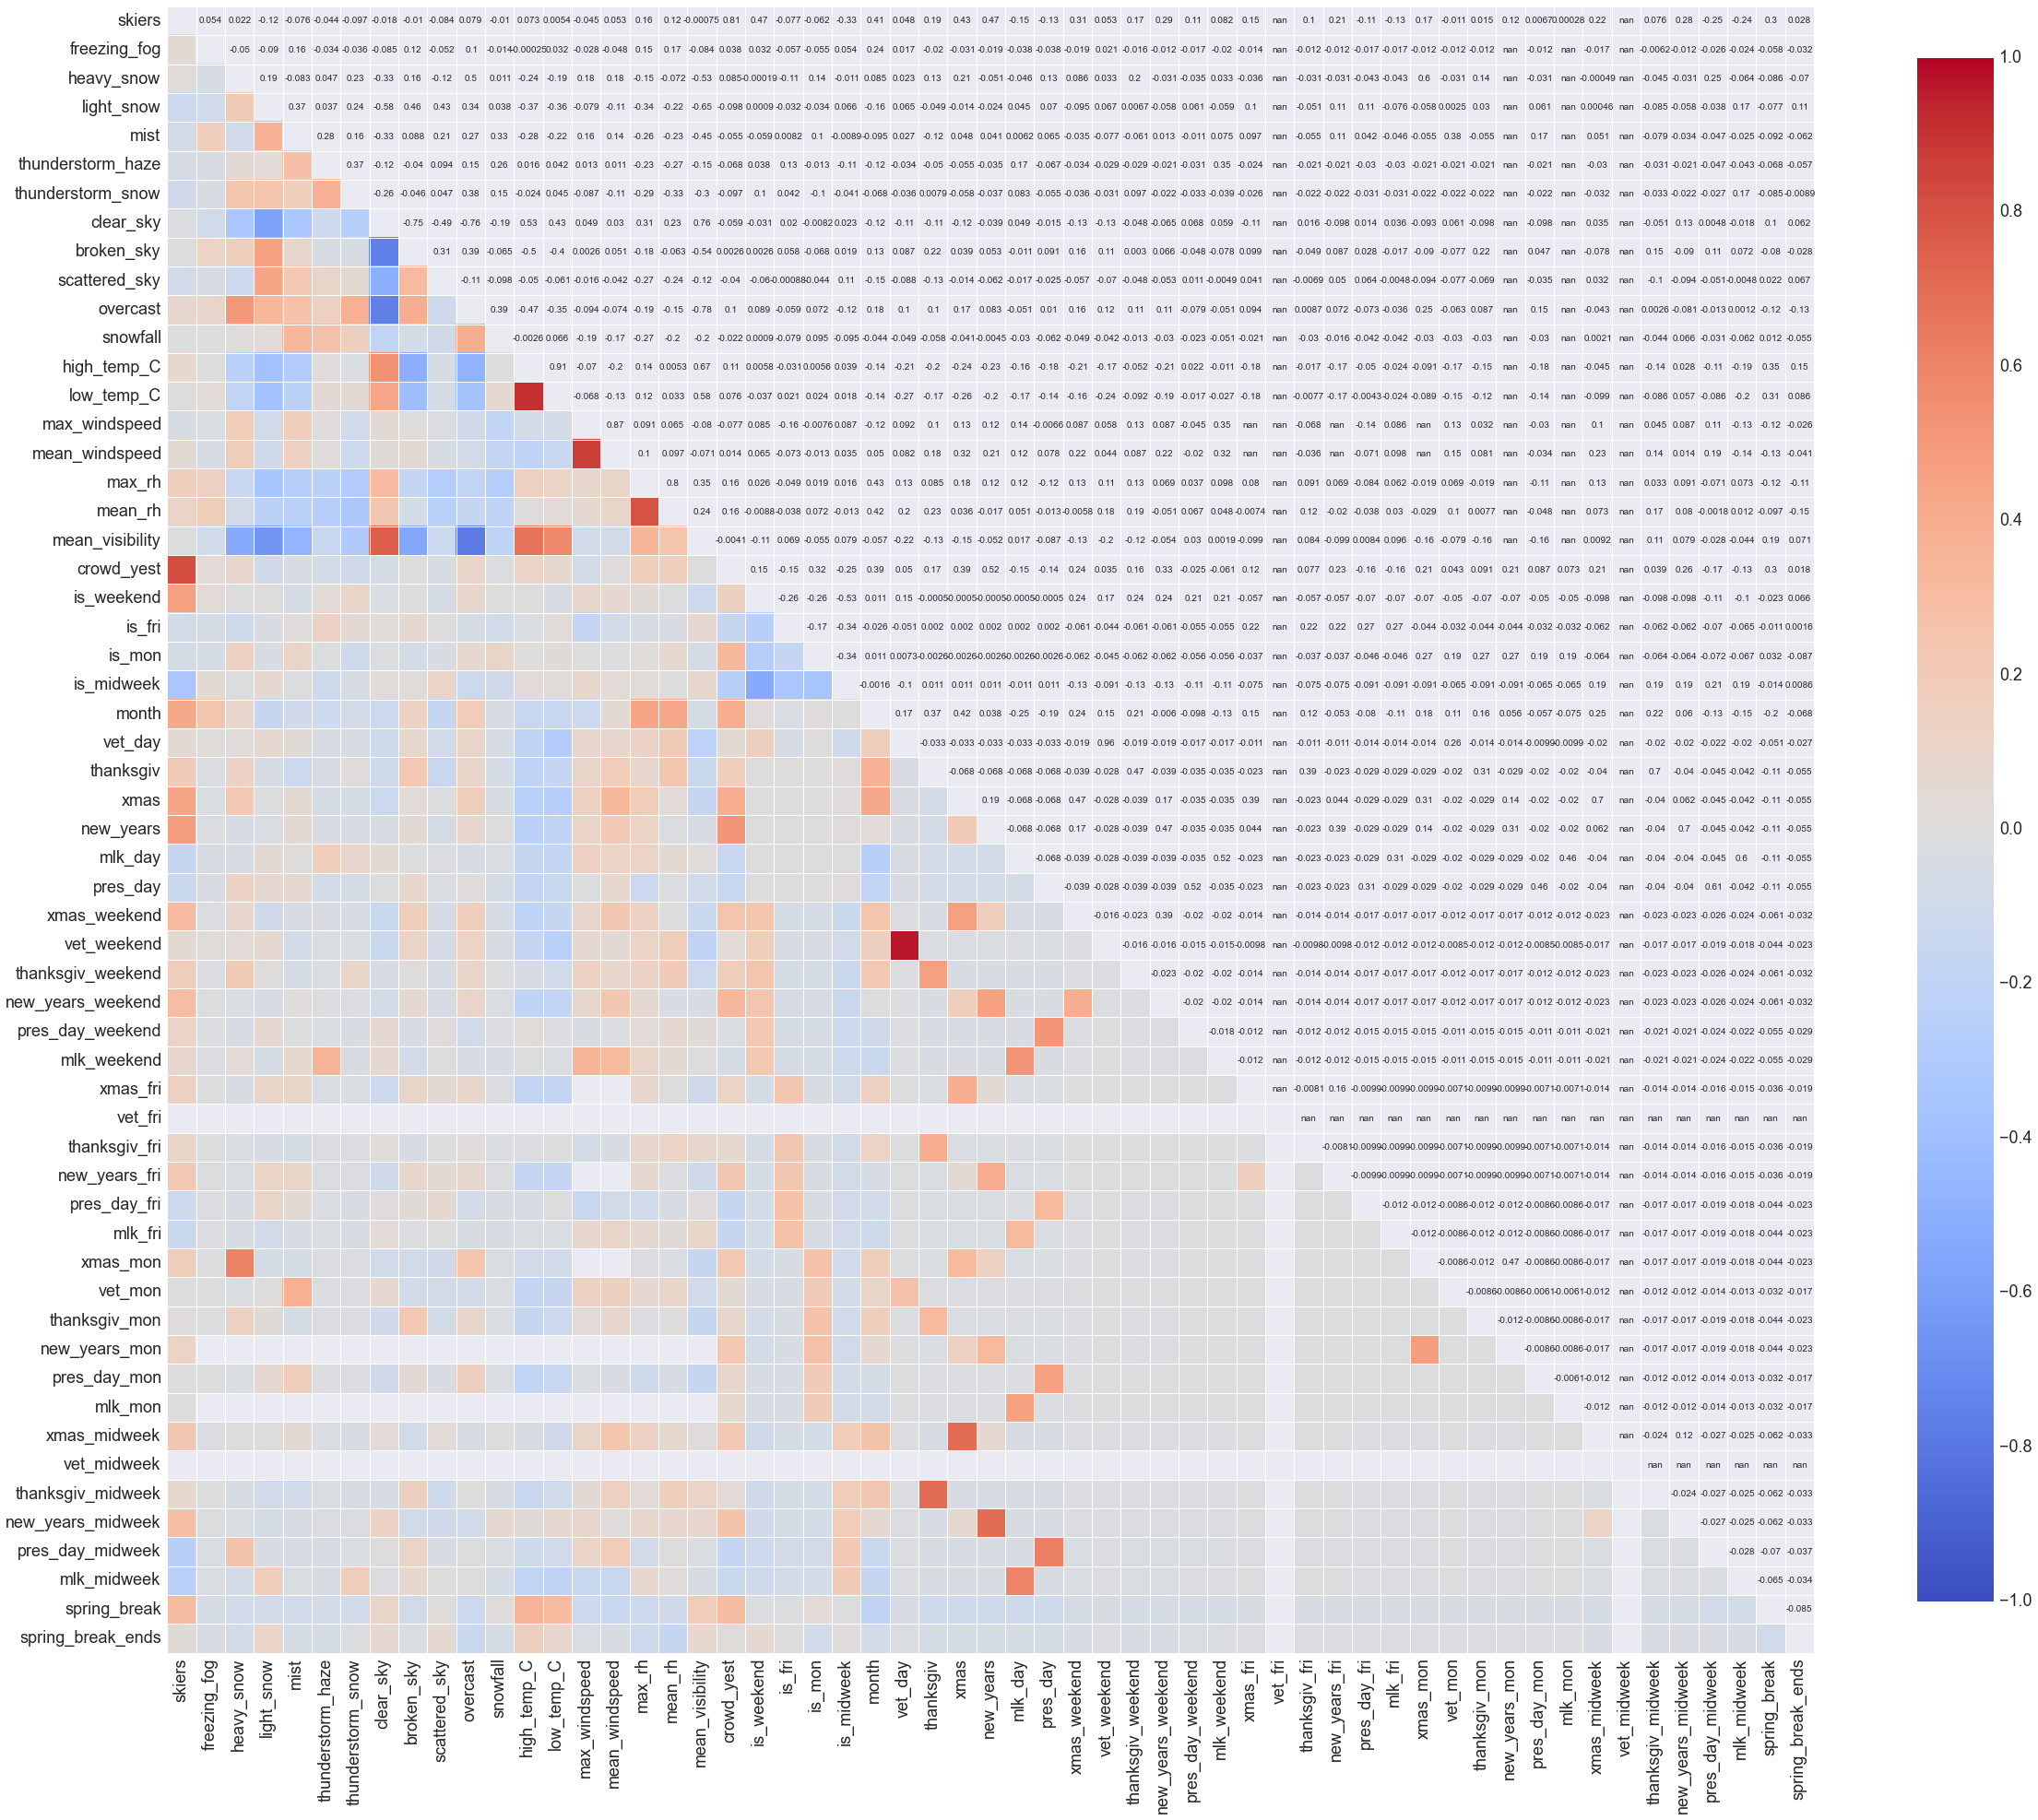

In [340]:
f, ax = plt.subplots(figsize=(40, 40))
sns.corrplot(df_all, annot=True, sig_stars=False,
             diag_names=False, ax=ax)

In [341]:
df_all.fillna(df_all.mean(), inplace=True)

,skiers,freezing_fog,heavy_snow,light_snow,mist,thunderstorm_haze,thunderstorm_snow,clear_sky,broken_sky,scattered_sky,...,pres_day_mon,mlk_mon,xmas_midweek,vet_midweek,thanksgiv_midweek,new_years_midweek,pres_day_midweek,mlk_midweek,spring_break,spring_break_ends
2014-11-15,1.351760,0.000000,0.140000,0.340000,0.000000,0.000000,0.000000,0.000000,0.240000,0.080000,...,0,0,0,0,0,0,0,0,0,0
2014-11-16,1.404012,0.015873,0.000000,0.047619,0.000000,0.000000,0.000000,0.079365,0.222222,0.111111,...,0,0,0,0,0,0,0,0,0,0
2014-11-17,1.034750,0.000000,0.000000,0.127273,0.727273,0.000000,0.000000,0.690909,0.018182,0.036364,...,0,0,0,0,0,0,0,0,0,0
2014-11-18,0.991433,0.014085,0.000000,0.000000,0.309859,0.000000,0.000000,0.492958,0.169014,0.225352,...,0,0,0,0,0,0,0,0,0,0
2014-11-19,0.988908,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.441176,0.102941,0.323529,...,0,0,0,0,0,0,0,0,0,0
2014-11-20,0.991239,0.000000,0.000000,0.013889,0.013889,0.000000,0.000000,0.194444,0.208333,0.416667,...,0,0,0,0,0,0,0,0,0,0
2014-11-21,1.024067,0.000000,0.000000,0.014085,0.000000,0.000000,0.000000,0.492958,0.056338,0.183099,...,0,0,0,0,0,0,0,0,0,0
2014-11-22,1.280860,0.000000,0.032787,0.163934,0.049180,0.000000,0.000000,0.655738,0.049180,0.245902,...,0,0,0,0,0,0,0,0,0,0
2014-11-23,1.429459,0.000000,0.422222,0.111111,0.000000,0.000000,0.022222,0.022222,0.177778,0.044444,...,0,0,0,0,0,0,0,0,0,0
2014-11-24,1.251335,0.000000,0.263158,0.184211,0.000000,0.000000,0.000000,0.000000,0.421053,0.052632,...,0,0,0,0,0,0,0,0,0,0


# Linear Regression

In [357]:
df_all.drop(['month'], axis=1, inplace=True)

In [358]:
from sklearn.cross_validation import cross_val_predict
from sklearn.cross_validation import cross_val_score


In [359]:
lr = linear_model.LinearRegression()

In [360]:
columns = list(df_all.columns.values)
columns.remove('skiers')

In [361]:
X = df_all[columns].values
y = df_all.skiers.values

In [362]:
mdl = lr.fit(X, y) 

In [363]:
cv_pred = cross_val_predict(lr, X, y, cv = 10)

In [364]:
cv_score = cross_val_score(lr, X, y, cv = 10)

In [365]:
cv_score

array([ 0.5790579 , -1.88218856,  0.17186588,  0.35927726,  0.8616394 ,
        0.84946245,  0.84276116,  0.80587355,  0.72776522, -0.83489486])

In [366]:
from sklearn import linear_model
clf = linear_model.Lasso(alpha=10)
lasso = clf.fit(X, y)
lasso_pred = lasso.predict(X)

In [367]:
pred = mdl.predict(X)
df_all['model_pred'] = pred
df_all['lasso_pred'] = cv_pred

In [368]:
ref_column = 'skiers'

In [369]:
def fitted_vs_ref_plot(df, ref_column):
    plt.figure(facecolor='w', figsize = (8,8))
    a, b, axes, label_size = plot_params()
    plt.plot(df[ref_column], df.model_pred, linestyle = '', marker = '.', alpha = 0.3)
    plt.xlabel('Skier Visits', size = label_size)
    plt.ylabel('Predicted Skier Visits', size = label_size)
    plt.plot([0, df.model_pred.max()], [0,df.model_pred.max()])
    #axes.set_ylim([-20,100])

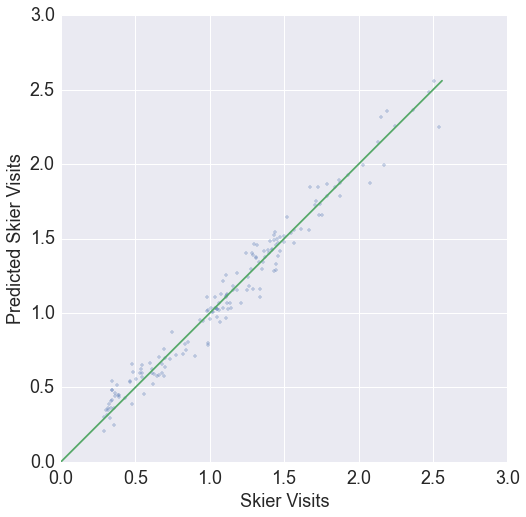

In [370]:
fitted_vs_ref_plot(df_all, ref_column)

In [373]:
def plot_fitted_and_ref_vs_time(df, ref_column):
    plt.figure(facecolor='w', figsize = (15,10))
    a, b, axes, label_size = plot_params()
    df[ref_column].plot(marker = '.',linestyle = '-', label = 'Reference Data')
    df.lasso_pred.plot(marker = '.',linestyle = '-', label = 'CV Predicted Data')
    #df.model_pred.plot(marker = '.',linestyle = '-', label = 'Linear Predicted Data')
    axes.set_ylim([0,3])
    plt.legend(fontsize = label_size)
    plt.ylabel('Normalized Skier Numbers', size = label_size)
    plt.xlabel('Date', size = label_size)

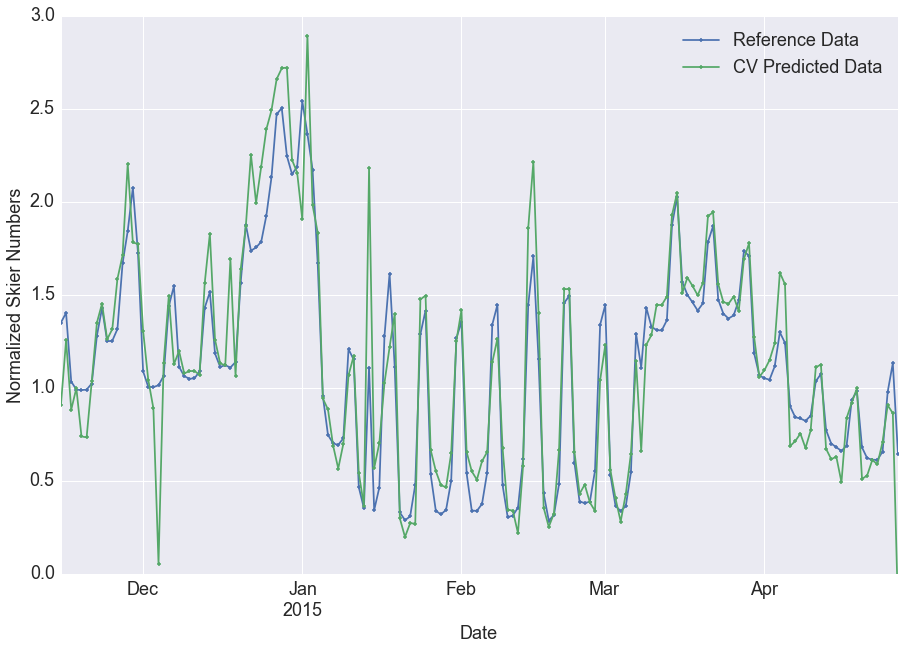

In [374]:
plot_fitted_and_ref_vs_time(df_all, ref_column)

In [304]:
df_all.head()

,skiers,freezing_fog,heavy_snow,light_snow,mist,thunderstorm_haze,thunderstorm_snow,clear_sky,broken_sky,scattered_sky,...,xmas_midweek,vet_midweek,thanksgiv_midweek,new_years_midweek,pres_day_midweek,mlk_midweek,spring_break,spring_break_ends,model_pred,lasso_pred
2014-11-15,1.351760,0.000000,0.14,0.340000,0.000000,0,0,0.000000,0.240000,0.080000,...,0,0,0,0,0,0,0,0,1.396584,1.746407
2014-11-16,1.404012,0.015873,0.00,0.047619,0.000000,0,0,0.079365,0.222222,0.111111,...,0,0,0,0,0,0,0,0,1.336776,1.574442
2014-11-17,1.034750,0.000000,0.00,0.127273,0.727273,0,0,0.690909,0.018182,0.036364,...,0,0,0,0,0,0,0,0,1.034750,1.109617
2014-11-18,0.991433,0.014085,0.00,0.000000,0.309859,0,0,0.492958,0.169014,0.225352,...,0,0,0,0,0,0,0,0,0.901205,0.947388
2014-11-19,0.988908,0.000000,0.00,0.000000,0.000000,0,0,0.441176,0.102941,0.323529,...,0,0,0,0,0,0,0,0,0.901186,0.962080


# Export Data

In [381]:
df_out = df_all.drop(['model_pred','skiers'], axis=1)

In [404]:
df_out.to_csv('../webpage_ski/df_all_features.csv')

In [383]:
df_out.head()

,freezing_fog,heavy_snow,light_snow,mist,thunderstorm_haze,thunderstorm_snow,clear_sky,broken_sky,scattered_sky,overcast,...,pres_day_mon,mlk_mon,xmas_midweek,vet_midweek,thanksgiv_midweek,new_years_midweek,pres_day_midweek,mlk_midweek,spring_break,spring_break_ends
2014-10-31,0.007779,0.044516,0.116006,0.091954,0.002148,0.003077,0.434859,0.117448,0.198366,0.236125,...,0,0,0,0,0,0,0,0,0,0
2014-11-01,0.000000,0.000000,0.000000,0.000000,0.027778,0.000000,0.847222,0.013889,0.138889,0.000000,...,0,0,0,0,0,0,0,0,0,0
2014-11-02,0.043478,0.014493,0.028986,0.072464,0.028986,0.000000,0.507246,0.086957,0.289855,0.115942,...,0,0,0,0,0,0,0,0,0,0
2014-11-03,0.370968,0.048387,0.096774,0.080645,0.000000,0.032258,0.096774,0.096774,0.080645,0.725806,...,0,0,0,0,0,0,0,0,0,0
2014-11-04,0.000000,0.000000,0.000000,0.013889,0.000000,0.000000,0.597222,0.000000,0.000000,0.291667,...,0,0,0,0,0,0,0,0,0,0


In [44]:
from datetime import datetime


In [60]:
date3 = datetime.strptime('11/1/2014',"%m/%d/%Y")

In [62]:
date2 = datetime.strptime('11/2/2014',"%m/%d/%Y")

In [63]:
dates = [date3]

In [64]:
dates.append(date2)

In [65]:
dates

[datetime.datetime(2014, 11, 1, 0, 0), datetime.datetime(2014, 11, 2, 0, 0)]

In [67]:
N = len(dates)

In [72]:
str(dates[0])[5:10]

'11-01'

In [405]:
date3

datetime.datetime(2014, 11, 1, 0, 0)

In [288]:
df_all.index[0]

Timestamp('2014-10-31 00:00:00')

In [385]:
feat = df_all.loc[date3]

In [406]:
date3 - pd.Timedelta(days=1)

datetime.datetime(2014, 10, 31, 0, 0)

In [403]:
dates = [date3]
dates.append(date3 - pd.Timedelta(days=1))

In [388]:
dates

[datetime.datetime(2014, 11, 1, 0, 0), datetime.datetime(2014, 10, 31, 0, 0)]

In [401]:
feat = df_out.loc[dates]

In [402]:
mdl.predict(feat)

array([ 1.24113897,  0.66253667])

In [308]:
len(X[:,1:])

2

In [ ]:
feat.head()

In [ ]:
float(intercept)

In [ ]:
crowd

In [ ]:
type(mdl)

In [ ]:
import cPickle as pickle

In [393]:
pickle_out = open('lin_regr.pkl', 'wb')
pickle.dump(mdl, pickle_out)
pickle_out.close()

In [ ]:
def load_classifier(fname):
   # load it again
   with open(fname, 'rb') as fid:
       clf = pickle.load(fid)    
       #clf = joblib.load(fname)

   return clf

In [ ]:
aa = load_classifier('lin_regr.pkl')

In [ ]:
aa

In [ ]:
crowd = aa.predict(feat[1:])

In [ ]:
def plot_params():
    size = 40
    a = plt.rc('xtick', labelsize = size)
    b = plt.rc('ytick', labelsize = size)
    return a, b, size

In [ ]:
def make_bar_chart(crowd, y_label, dates):
    a, b, label_size = plot_params()
    N = len(crowd)


    ind = np.arange(N)  # the x locations for the groups
    width = 0.35      # the width of the bars

    fig, ax = plt.subplots(figsize=(20, 10), facecolor='white', frameon=False)
    #plt.box(on='off')
    rects1 = ax.bar(ind, crowd, width, color='#bdbdbd', edgecolor = "none")

    # add some text for labels, title and axes ticks
    ax.set_ylabel(y_label, size = label_size)
    ax.set_title(' ')
    ax.set_xticks(ind + width)
    #tick_labels = dates.tolist()
    #ax.set_xticklabels(tick_labels)
    ax.grid(False)
    #plt.ylim([0,18])
    #make the border lines lighter
    [i.set_linewidth(0.1) for i in ax.spines.itervalues()]

    #remove the y axis
    #frame1 = plt.gca()
    #frame1.axes.get_yaxis().set_visible(False)

    #draw legend
    #ax.legend( (rects1[0], rects2[0]), ('Base Features', 'Best Features') , loc = 'best', fontsize = label_size, frameon=False)

    return fig